<a href="https://colab.research.google.com/github/footprinthere/DeepLearningWithTensorflow/blob/main/PartOfSpeechClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part of Speech Classifier

### 필요한 모듈 import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pprint import pprint

### 데이터 전처리

입력으로 사용할 문장 4개와, 각 단어의 품사 정보를 포함한 label 데이터이다.

In [2]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

token을 정수 형태의 index로 변환하기 위한 dictionary를 생성한다.

In [3]:
# create token dictionary for words
word_list = ['<pad>'] + sorted(set(sum(sentences, [])))
word2idx = {word : idx for idx, word in enumerate(word_list)}

# create token dictionary for pos
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

생성한 dictionary를 이용해 token을 index로 변환하고, 여기에 padding을 수행해 길이를 10으로 맞춰준다.  
또한 masking을 수행하기 위한 배열을 추가로 생성한다.

In [4]:
# convert sequence of tokens to sequence of indices
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
x_data_len = list(map(lambda sentence : len(sentence), sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding
maxlen = 10
x_data = keras.preprocessing.sequence.pad_sequences(
    x_data, maxlen=maxlen, padding='post', truncating='post'
)
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
y_data = keras.preprocessing.sequence.pad_sequences(
    y_data, maxlen=maxlen, padding='post', truncating='post'
)

print(x_data)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


위에서 가공한 데이터를 기반으로 Dataset을 생성한다.  
여기에는 sequence loss 계산에 사용하기 위한, padding 이전의 길이 정보가 포함된다.

In [5]:
# generate data pipeline
batch_size = 2
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len)).\
    shuffle(buffer_size=4).batch(batch_size)

### 모델 생성

학습에 활용할 many-to-many RNN model을 생성한다.

In [6]:
# create RNN model
num_classes = len(pos2idx)
hidden_size = 10
dim = len(word2idx)
one_hot = np.eye(dim)

model = keras.Sequential()
model.add(layers.Embedding(
    input_dim=dim, output_dim=dim, input_length=maxlen,
    trainable=False, mask_zero=True,
    embeddings_initializer=keras.initializers.Constant(one_hot)
))
model.add(layers.SimpleRNN(units=hidden_size, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(units=num_classes)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 15)            225       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 10)            260       
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 8)             88        
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


### 모델 학습 준비

모델의 loss를 계산하는 함수를 정의한다.  
* tf.sequence_mask(length, maxlen)을 활용해 masking에 사용할 배열을 생성할 수 있다.
* 미리 계산해둔 x_len 정보를 cast 한 배열 valid_len을 선언한다.
* sparse_categorical_crossentropy()를 사용해 loss를 계산하고, 여기에 mask를 곱해 pad token에 대해 계산된 loss를 제외한다.
* 그 결과를 평균해 sequence loss를 계산하고, 이것들을 다시 평균해 최종 loss를 구한다.

In [7]:
# define loss function
def loss_func(model, x, y, x_len, maxlen):
    mask = tf.sequence_mask(x_len, maxlen, dtype=tf.float32)
    valid_len = tf.cast(x_len, dtype=tf.float32)
    sequence_loss = keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * mask
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_len
    return tf.reduce_mean(sequence_loss)

학습에 활용할 gradient를 계산하는 함수를 정의한다.

In [8]:
# define gradient function
def grad_func(model, x, y, x_len, maxlen):
    with tf.GradientTape() as tape:
        loss = loss_func(model, x, y, x_len, maxlen)
    return tape.gradient(loss, model.variables), loss

학습에 활용할 hyper parameter와 optimizer를 생성한다.

In [9]:
lr = 0.1
epochs = 30
opt = tf.optimizers.Adam(learning_rate=lr)

### 모델 학습

생성한 모델과 데이터셋을 바탕으로 학습을 수행한다.

In [10]:
# train
loss_hist = []

for epoch in range(1, epochs+1):
    avg_loss = 0
    tr_step = 0

    for x, y, x_len in dataset:
        grads, loss = grad_func(model, x, y, x_len, maxlen)
        opt.apply_gradients(zip(grads, model.variables))
        avg_loss += loss
        tr_step += 1
    avg_loss /= tr_step
    loss_hist.append(avg_loss)

    if epoch % 5 == 0:
        print("epoch: {:3}, loss: {:.4f}".format(epoch, avg_loss))

epoch:   5, loss: 0.0834
epoch:  10, loss: 0.0041
epoch:  15, loss: 0.0010
epoch:  20, loss: 0.0005
epoch:  25, loss: 0.0004
epoch:  30, loss: 0.0003


주어진 label 데이터와 모델이 예측한 결과를 비교해본다.

In [11]:
pred = model.predict(x_data)
pred = np.argmax(pred, axis=-1) * x_data_mask

pprint(list(map(
    lambda row : [idx2pos.get(elm) for elm in row],
    pred.astype(np.int32).tolist()
)), width=128)
pprint(pos)

[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


학습 과정에서 loss가 어떻게 변화했는지 그래프로 확인해본다.

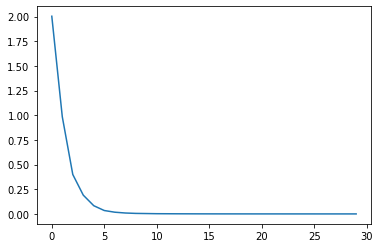

In [12]:
plt.plot(loss_hist)